In [3]:
import time

import torch
import einops
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset

from taker import Model
from huggingface_hub import InferenceClient
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from matplotlib.lines import Line2D

from scipy.ndimage import sobel

from tqdm import tqdm

import openpyxl
import pandas as pd
import ast

In [8]:
# Generate activations

#m = Model("nickypro/tinyllama-15m", dtype="fp16")
#m = Model("google/gemma-2b-it", device_map="cuda")
m = Model("google/gemma-2-9b-it", dtype="hqq8", device_map="cuda")

# Model attributes
print(m.cfg.d_model) # 288 model width
print(m.cfg.d_mlp)   # 768 mlp width
print(m.cfg.n_heads) # 6 heads
print(m.cfg.d_head)  # 48 head size
print(m.cfg.d_vocab) # 32000 token options

# Calculate layers to plot
x = 18
step = (x - 2) / 5
loop_layers = [int(1 + i * step) for i in range(6)]

print(loop_layers)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model 'google/gemma-2-9b-it' with hqq8:
- Added 672 hooks across 42 layers
3584
14336
16
256
256000
[1, 4, 7, 10, 13, 17]


# Split Up Texts


In [71]:
# function to find newline tokens in text

def find_double_newline_tokens_in_text(text, model):
    ids = model.get_ids(text).flatten()
    double_newline_positions = []

    for i, _id in enumerate(ids):
        token = m.tokenizer.decode(_id)
        if token == "\n\n":
            double_newline_positions.append(i)

    return double_newline_positions

# Usage example:
text13 = ".\n\nThe old Ford rumbled to life, its engine a symphony of coughs and splutters.  Packed with mismatched luggage and overflowing with anticipation, we set off on a road trip across the country.  Miles melted away, replaced by sun-drenched highways, towering redwoods, and the endless expanse of the desert. We shared stories, sang along to forgotten tunes, and laughed until our sides ached. Every stop was an adventure, every roadside diner a memory in the making.  As the sun dipped below the horizon, painting the sky in fiery hues, we knew this was a journey we'd never forget.\n\nRegular vehicle maintenance is crucial for ensuring a safe and enjoyable road trip.  Neglecting routine checks and services can lead to breakdowns, costly repairs, and potentially dangerous situations.  Regular oil changes, tire rotations, and fluid top-ups keep your engine running smoothly and prevent premature wear and tear.  Inspecting brakes, lights, and belts ensures your"

# Assuming 'm' is your model object
double_newline_positions = find_double_newline_tokens_in_text(text13, m)

# Print the positions in the desired format
print(", ".join(map(str, double_newline_positions)))

2, 129


In [82]:
#Function to read from excel file and pull back token number of new line tokens

def find_double_newline_tokens_in_text(text, model):
    ids = model.get_ids(text).flatten()
    double_newline_positions = []

    for i, _id in enumerate(ids):
        token = model.tokenizer.decode(_id)
        if token == "\n\n":
            double_newline_positions.append(i)

    return double_newline_positions

def process_excel_file(input_file, output_file, model):
    # Read the Excel file
    df = pd.read_excel(input_file, header=None)

    # Create a new column for the results
    df[1] = ''

    # Process each row
    for index, row in df.iterrows():
        text = row[0]

        # Process the text
        try:
            # Try to interpret the cell content as a Python literal
            text = ast.literal_eval(text)
        except:
            # If that fails, use the content as-is
            pass

        # Ensure newlines are actual newlines, not string literals
        text = text.replace('\\n', '\n')

        # Find double newline positions
        double_newline_positions = find_double_newline_tokens_in_text(text, model)

        # Convert positions to string and store in the second column
        df.at[index, 1] = ', '.join(map(str, double_newline_positions))

    # Save the results to a new Excel file
    df.to_excel(output_file, index=False, header=False)

# Usage
input_file  = "getNewline.xlsx"
output_file = "getNewlineOutput.xlsx"

# Assuming 'm' is your model object
process_excel_file(input_file, output_file, m)

print(f"Processing complete. Results saved to {output_file}")

Processing complete. Results saved to getNewlineOutput.xlsx


# Make Plots

In [9]:
# READ EXCEL PROMPTS AND ORIGINS
def read_data_from_excel(filename):
    texts = []
    origins = []
    workbook = openpyxl.load_workbook(filename)
    sheet = workbook.active
    total_rows = sheet.max_row

    for row in sheet.iter_rows(min_row=1, values_only=True):
        if len(row) >= 2:
            text = str(row[0]).strip() if row[0] is not None else ''
            origin_value = row[1]

            if text and origin_value is not None and isinstance(origin_value, (int, float)):
                texts.append(text)
                origins.append((int(origin_value), int(origin_value)))

    print(f"Total rows in Excel: {total_rows}")
    print(f"Texts read: {len(texts)}")

    return texts, origins

In [10]:
# FINAL FUNCTION WITH LAYER SELECTION
def plot_layer_metrics_overlay_layers(m, texts, origins, layers_to_plot=None):
    num_layers = 42  # Total number of layers
    window_size = 50  # Number of tokens to show on each side of the origin

    # If layers_to_plot is not provided, use all layers
    if layers_to_plot is None:
        layers_to_plot = list(range(num_layers))
    else:
        # Ensure layers_to_plot contains valid layer indices
        layers_to_plot = [i for i in layers_to_plot if 0 <= i < num_layers]

    # Initialize lists to store cosine similarities and masks for selected layers
    all_coss = [[] for _ in layers_to_plot]
    all_masks = [[] for _ in layers_to_plot]

    # Process each text and its corresponding origin
    for text, origin in tqdm(zip(texts, origins)):
        with torch.no_grad():
            _in2, _attn, _mlp2, _out2 = m.get_text_activations(text.replace("\\n", "\n"))

        # For each selected layer, compute cosine similarity, crop, and store
        for idx, i in enumerate(layers_to_plot):
            vecs_i = _attn[0][i]  # Select the layer

            # Normalize the vectors
            norm = torch.norm(vecs_i, dim=-1, keepdim=True)
            norm = torch.where(norm == 0, torch.ones_like(norm), norm)  # Avoid division by zero
            normed_vecs_i = vecs_i / norm

            # Compute cosine similarity
            coss = torch.mm(normed_vecs_i, normed_vecs_i.t())

            # Crop the cosine similarity matrix to the window around the origin
            start = max(0, origin[0] - window_size)
            end = min(coss.shape[0], origin[0] + window_size)
            cropped_coss = coss[start:end, start:end]

            # Create a mask for the cropped region (1 for real data, 0 for padding)
            mask = torch.ones_like(cropped_coss)

            # Pad if necessary to ensure we have exactly 2*window_size tokens
            pad_left = max(0, window_size - origin[0])
            pad_right = max(0, (origin[0] + window_size) - coss.shape[0])
            padded_coss = torch.nn.functional.pad(cropped_coss, (pad_left, pad_right, pad_left, pad_right))
            padded_mask = torch.nn.functional.pad(mask, (pad_left, pad_right, pad_left, pad_right))

            all_coss[idx].append(padded_coss)
            all_masks[idx].append(padded_mask)

    # Calculate masked average cosine similarity for each selected layer
    avg_coss = []
    for layer_coss, layer_masks in zip(all_coss, all_masks):
        stacked_coss = torch.stack(layer_coss)
        stacked_masks = torch.stack(layer_masks)
        sum_coss = torch.sum(stacked_coss * stacked_masks, dim=0)
        sum_masks = torch.sum(stacked_masks, dim=0)
        avg_coss.append(sum_coss / (sum_masks + 1e-10))  # Add small epsilon to avoid division by zero

    # Plotting
    num_plots = len(layers_to_plot)
    num_cols = min(4, num_plots)  # Use up to 6 columns
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows), dpi=600)  # Increased figure height
    axes = np.array(axes).reshape(-1)  # Ensure axes is always a 1D array

    # Create a single colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

    for idx, i in enumerate(layers_to_plot):
        ax = axes[idx]
        sns.heatmap(avg_coss[idx].detach().cpu().float(), ax=ax, square=True,
                    vmin=0, vmax=1, center=0,  # Set color range from -1 to 1
                    cbar=idx == 0, cbar_ax=None if idx else cbar_ax, cmap='icefire')

        # Set main title and subtitle
        ax.set_title(f"Layer {i+1}", fontsize=18)

        # Set ticks and labels
        tick_locations = np.linspace(0, 2*window_size, 9)  # 9 ticks for a nice distribution
        ax.set_xticks(tick_locations)
        ax.set_yticks(tick_locations)

        # Add origin lines at the center
        ax.axvline(x=window_size, color='white', alpha=0.5, linestyle=':')
        ax.axhline(y=window_size, color='white', alpha=0.5, linestyle=':')

    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    #fig.suptitle('Average Cosine Similarity Across Selected Layers (±50 Tokens Around Topic Change)', fontsize=14)

    # Adjust the layout
    plt.tight_layout(rect=[0.03, 0.05, 0.9, 0.95])  # Increased bottom margin
    plt.subplots_adjust(left=0.05, right=0.9, top=0.88, bottom=0.05, wspace=0.2, hspace=0.1)


    plt.show()

Total rows in Excel: 800
Texts read: 799


0it [00:00, ?it/s]

799it [05:59,  2.23it/s]
/tmp/ipykernel_883434/1371159268.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.05, 0.9, 0.95])  # Increased bottom margin


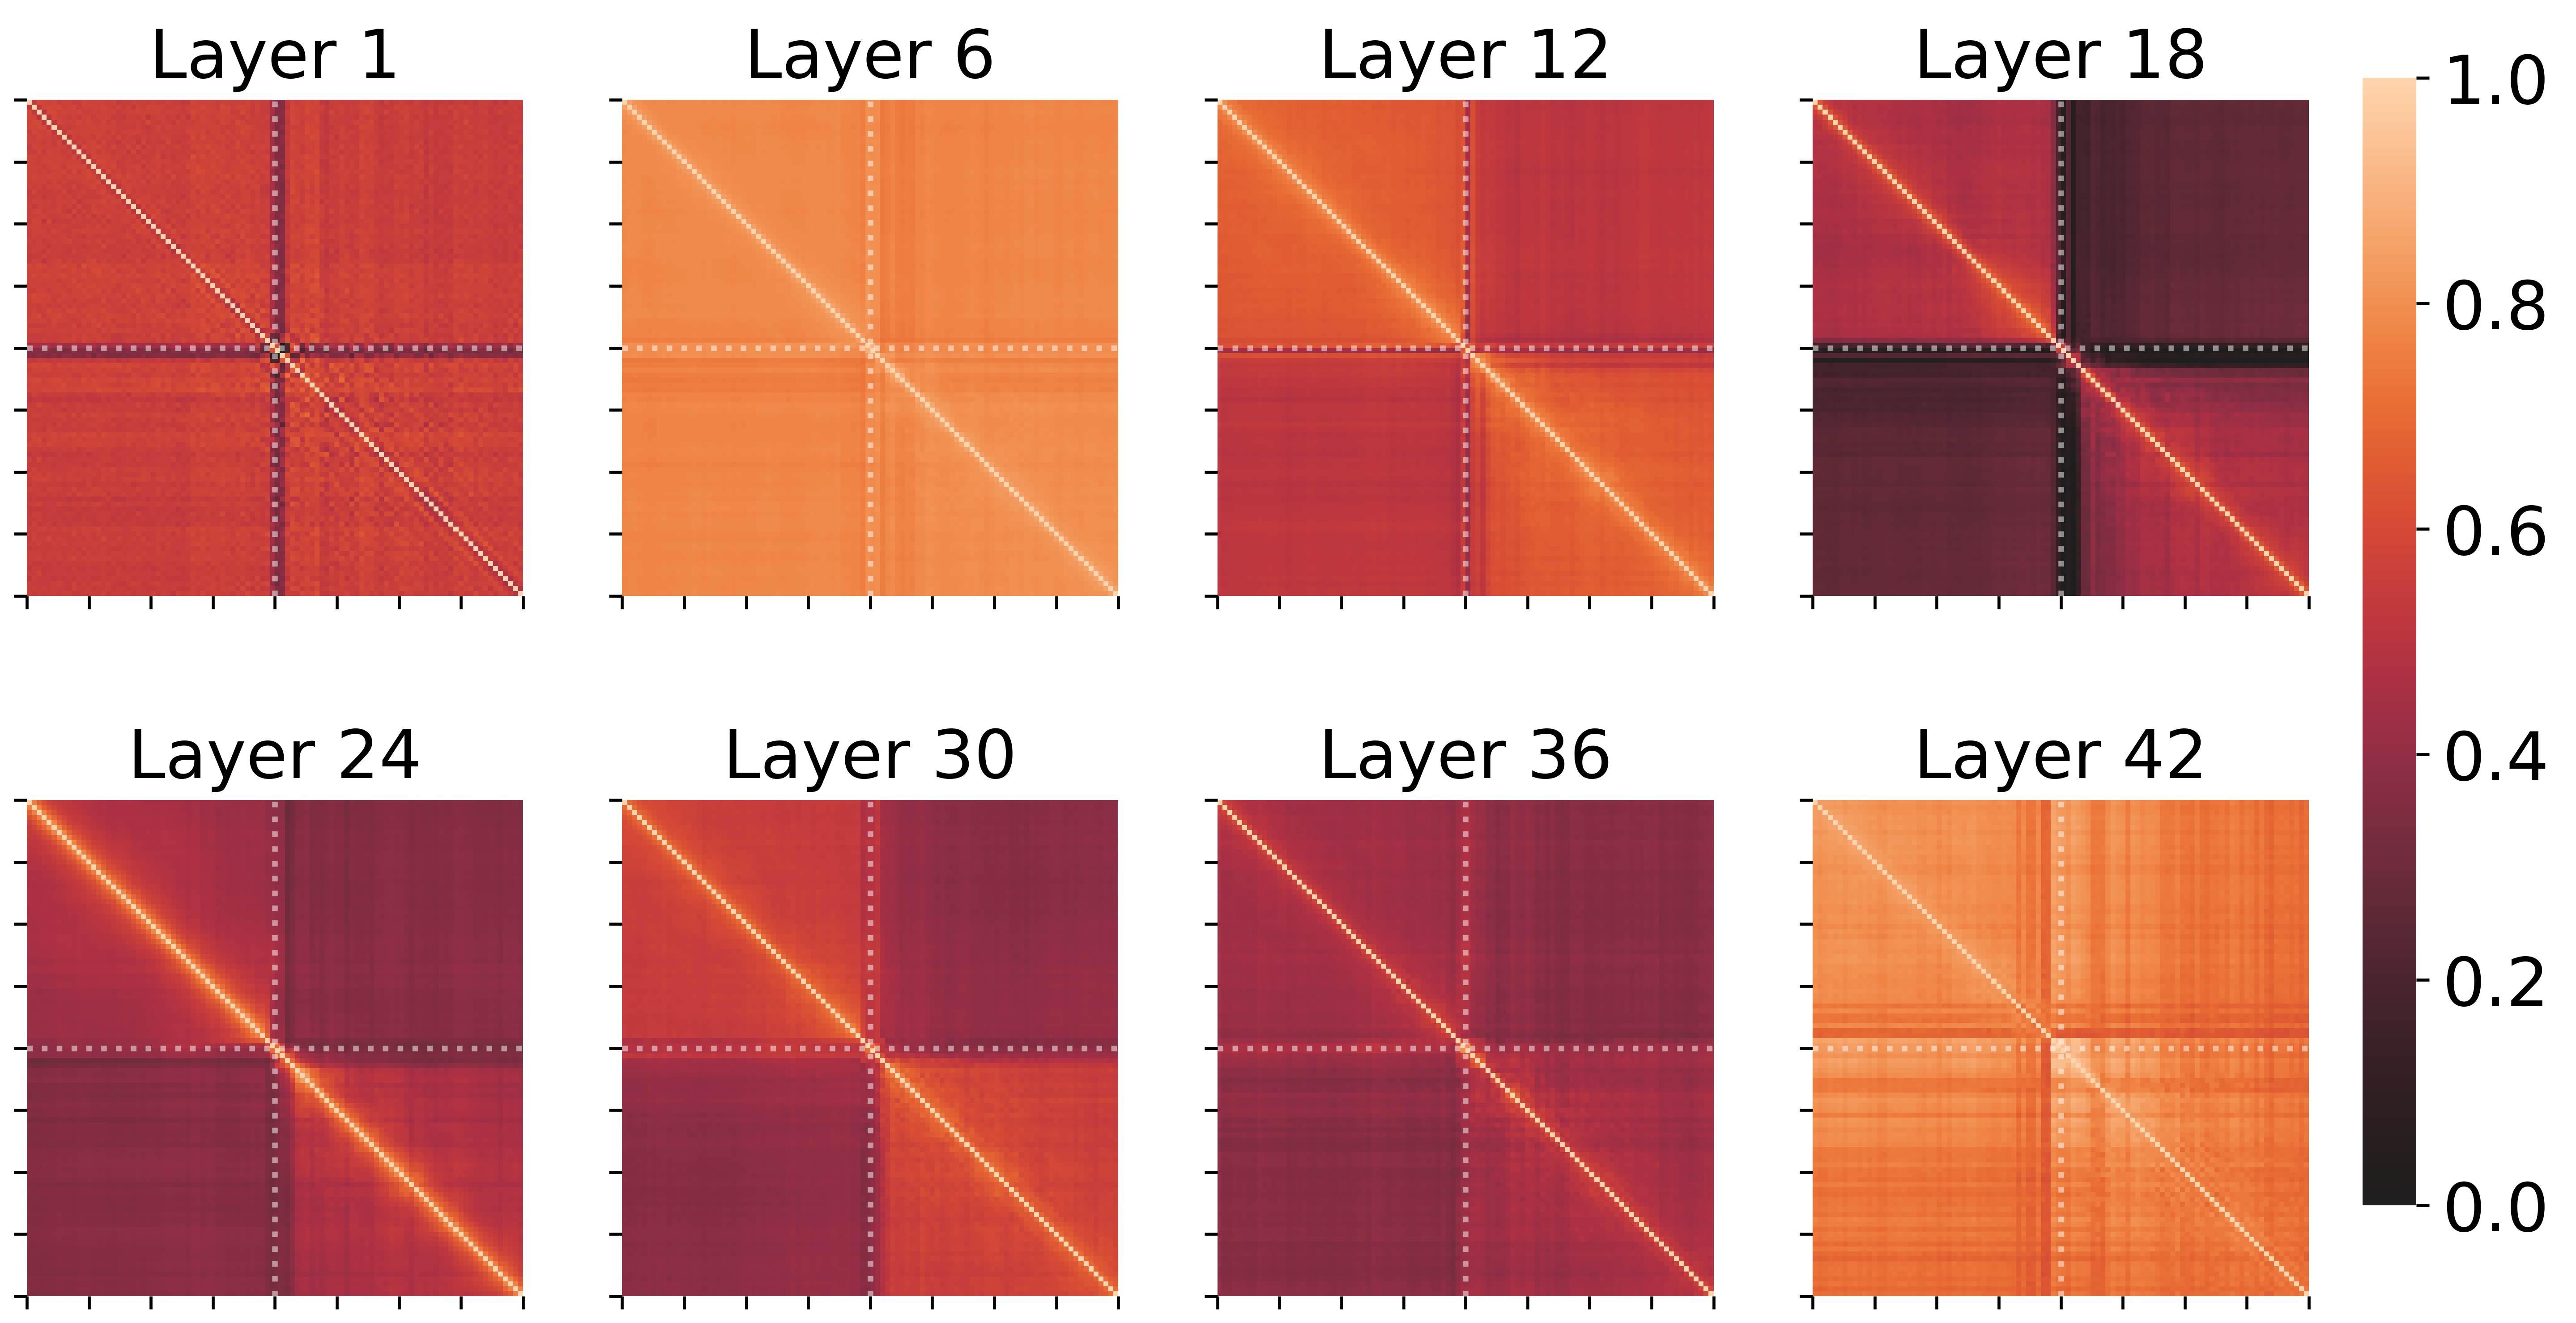

In [11]:
texts1, origins1 = read_data_from_excel('promptsOrigins9b.xlsx')
plot_layer_metrics_overlay_layers(m, texts1, origins1, layers_to_plot=[0,5,11,17,23,29,35,41])

Total rows in Excel: 800
Texts read: 799


0it [00:00, ?it/s]

799it [05:59,  2.22it/s]


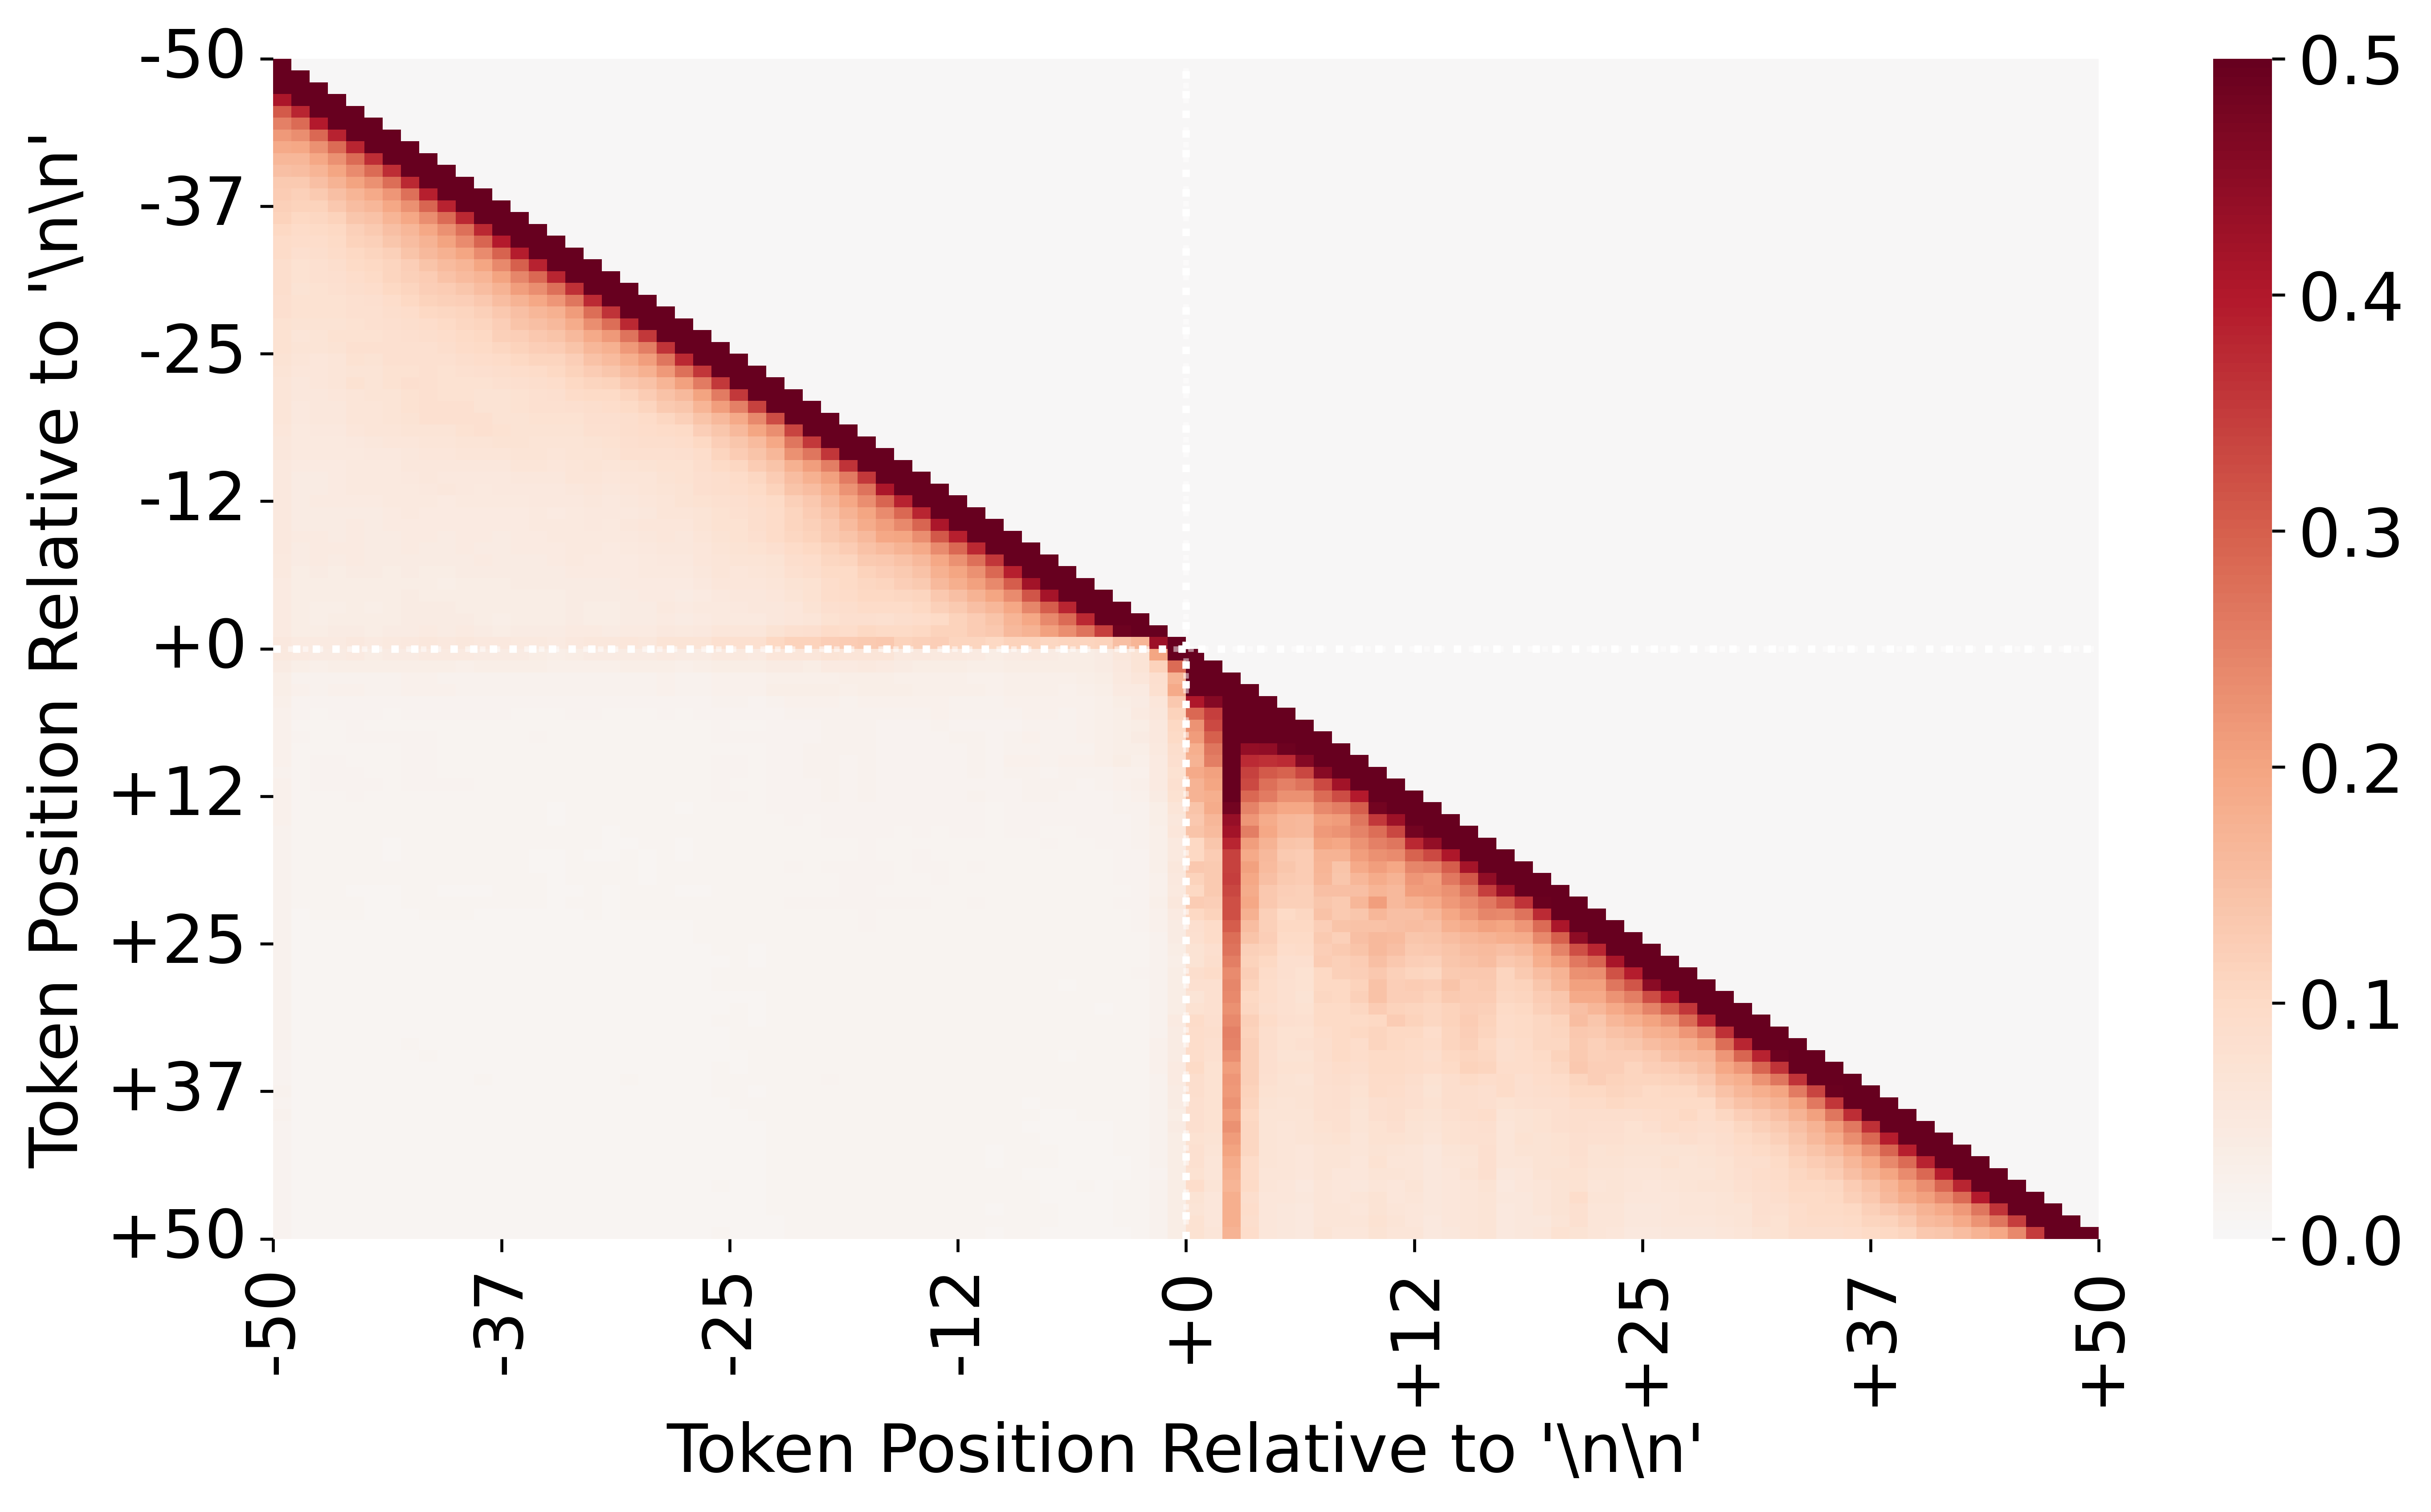

In [28]:
def plot_mean_attention_heatmap(m, texts, origins, window_size=50):
    plt.figure(figsize=(10, 6), dpi=600)
    # set the text size to 12
    plt.rcParams.update({'font.size': 18})

    all_mean_weights = []
    all_masks = []

    for text, origin in tqdm(zip(texts, origins)):
        with torch.no_grad():
            attn_weights = m.get_attn_weights(text.replace("\\n", "\n"))

        mean_weights = attn_weights[0].mean(dim=0).sum(dim=0).cpu().float().numpy()

        # Crop the mean_weights to the window around the origin
        start = max(0, origin[0] - window_size)
        end = min(mean_weights.shape[0], origin[0] + window_size)
        cropped_weights = mean_weights[start:end, start:end]

        # Create a mask for the cropped region (1 for real data, 0 for padding)
        mask = np.ones_like(cropped_weights)

        # Pad if necessary to ensure we have exactly 2*window_size tokens
        pad_left = max(0, window_size - origin[0])
        pad_right = max(0, (origin[0] + window_size) - mean_weights.shape[0])
        padded_weights = np.pad(cropped_weights, ((pad_left, pad_right), (pad_left, pad_right)), 'constant')
        padded_mask = np.pad(mask, ((pad_left, pad_right), (pad_left, pad_right)), 'constant')

        all_mean_weights.append(padded_weights)
        all_masks.append(padded_mask)

    # Calculate masked average mean weights
    stacked_weights = np.stack(all_mean_weights)
    stacked_masks = np.stack(all_masks)
    sum_weights = np.sum(stacked_weights * stacked_masks, axis=0)
    sum_masks = np.sum(stacked_masks, axis=0)
    avg_weights = sum_weights / (sum_masks + 1e-10)  # Add small epsilon to avoid division by zero

    sns.heatmap(avg_weights, center=0.0, vmax=.5, vmin=0, cmap="RdBu_r", cbar=True)

    # Add origin lines at the center
    plt.axvline(x=window_size, color='white', alpha=0.5, linestyle=':')
    plt.axhline(y=window_size, color='white', alpha=0.5, linestyle=':')

    # Add vertical and horizontal line in the center showing the center as ":"
    plt.axvline(x=window_size, color='white', alpha=1, linestyle=':', linewidth=2)
    plt.axhline(y=window_size, color='white', alpha=1, linestyle=':', linewidth=2)

    # plt.title("Average Mean Attention Weights Around Topic Change", fontsize=12)
    plt.xlabel("Token Position Relative to '\\n\\n'", fontsize=18)
    plt.ylabel("Token Position Relative to '\\n\\n'", fontsize=18)

    # Set ticks and labels
    tick_locations = np.linspace(0, 2*window_size, 9)  # 9 ticks for a nice distribution
    tick_labels = [f"{int(x - window_size):+d}" for x in tick_locations]
    plt.xticks(tick_locations, tick_labels, fontsize=18)
    plt.yticks(tick_locations, tick_labels, fontsize=18)

    plt.tight_layout()
    plt.show()

# Usage
texts1, origins1 = read_data_from_excel('promptsOrigins9b.xlsx')
plot_mean_attention_heatmap(m, texts1, origins1)